# DonorsChoose.org
***
<b>Class: </b>CMPE_257 Machine Learning <br>
<b>Team: </b>Vidhi Shah, Sithara KrishnaMurthy, Pragya Gautam, Reetika Goel <br>
***
<b>Business Objective:</b> <br>There is fantastic saying by Mother Teresa that says “It’s not how much we give but how much love we put into giving.”
In this age, technology has made it so much easier for everyone to give and by that it has helped millions of people globally. Donations can be made through a small text message or just a simple click of a button. The team at DonorsChoose.org does an amazing job to support the public education there by bringing classroom dreams to life for teachers and students all over United States.

Speaking about statistics, It has already raised $685 million through 3 million people and partners funding 1.1 million DonorsChoose.org projects. But teachers still spend more than a billion dollars of their own money on classroom materials. To get students what they need to learn and based on the data available regarding the donors, donations and classroom materials requirement, the organization would like to pair up donors to the classroom requests that will most motivate them to make an additional gift.

The email marketing campaigns will surely be able to connect donors with the projects that most inspires them and we “The Seekers” team, as data scientists or as machine learning engineers are ready to take up the challange to find and help them.<br><br>
<b>Kaggle Link:</b> https://www.kaggle.com/donorschoose/io/home

As our dataset is too large, we have extracted a sample/subset of records to perform the classification and understand the data.

#### Objective of this Notebook:
* For a new Project, predict the possible range of amount, for Donations received from Donors, based on project cost, resources required, school details and donor details. 
* Predict the 'School Metro Type' based on some of the features of a Project like Project cost, Donation amount etc.



In [0]:
# import libraries
import pandas as pd
import numpy as np
from string import Template

import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import ensemble

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


##  Read CSVs
@Author: Team

In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# read csvs
df_donations = pd.read_csv("/content/drive/Team Drives/The Seekers - Machine Learning Project/DataSets/Donations.csv")
df_donors = pd.read_csv("/content/drive/Team Drives/The Seekers - Machine Learning Project/DataSets/Donors.csv")
df_projects = pd.read_csv("/content/drive/Team Drives/The Seekers - Machine Learning Project/DataSets/Projects.csv")
df_schools = pd.read_csv("/content/drive/Team Drives/The Seekers - Machine Learning Project/DataSets/Schools.csv")

In [0]:
# print inital shapes for all csvs
print("Shape of Donations Data:",df_donations.shape,'\n')
print("Shape of Donors Data:",df_donors.shape,'\n')
print("Shape of Projects Data:",df_projects.shape,'\n')

Shape of Donations Data: (4687884, 7) 

Shape of Donors Data: (2122640, 5) 

Shape of Projects Data: (1110017, 18) 



## Pre-Processing

### Null Check / Type Conversion / Drop Nulls / Drop Columns

In [0]:
# Checking the nulls count of given files

def null_check(df,name):
    print(name)
    print('Number of rows and cols are {} and {}'.format(df.shape[0],
            df.shape[1]))
    print('Number of nulls are \n{}'.format(df.isnull().sum()),'\n')
    
def type_convert(df,column,dtype):
    print("Data Type before conversion:",df[column].dtypes,'\n')
    df[column] = df[column].astype(dtype)
    print("Data Type after conversion:",df[column].dtypes)
 
def drop_col(df,column):
    print("Column to Drop is :",column,'\n')
    df.drop(columns=column,axis=1,inplace=True)

In [0]:
null_check(df_donations,'Donations')
null_check(df_donors,'Donors')
null_check(df_projects,'Projects')

Donations
Number of rows and cols are 4687884 and 7
Number of nulls are 
Project ID                             0
Donation ID                            0
Donor ID                               0
Donation Included Optional Donation    0
Donation Amount                        0
Donor Cart Sequence                    0
Donation Received Date                 0
dtype: int64 

Donors
Number of rows and cols are 2122640 and 5
Number of nulls are 
Donor ID                 0
Donor City          213097
Donor State              0
Donor Is Teacher         0
Donor Zip           180060
dtype: int64 

Projects
Number of rows and cols are 1110017 and 18
Number of nulls are 
Project ID                               0
School ID                                0
Teacher ID                               0
Teacher Project Posted Sequence          0
Project Type                             0
Project Title                            6
Project Essay                            1
Project Short Description      

### Merging Donations + Donors + Projects + Schools to get all the donors with donations count >=2

In [0]:
# Get the donations count per donor ID
donations_count = pd.DataFrame(
    df_donations.groupby("Donor ID")['Project ID'].count()
)

donations_count.reset_index(inplace = True)
donations_count.rename(columns = {'Project ID':'Donations_Count'},
                       inplace = True)
donations_count.head()

,Donor ID,Donations_Count
0,00000ce845c00cbf0686c992fc369df4,1
1,00002783bc5d108510f3f9666c8b1edd,1
2,00002d44003ed46b066607c5455a999a,11
3,00002eb25d60a09c318efbd0797bffb5,5
4,0000300773fe015f870914b42528541b,1


In [0]:
# Select target donors with donations count>= 2
target_donors = donations_count[donations_count['Donations_Count'] >= 2]

# For all the donors above get all information from donations csv and sort it by donation date desc

target_donations = df_donations[df_donations['Donor ID'].isin(target_donors['Donor ID'])]
target_donations = target_donations.sort_values('Donation Received Date', ascending=False)

# Drop duplicate values and populate target_donors with only Donor ID

target_donors = target_donations.drop_duplicates('Donor ID', keep='first')['Donor ID']
target_donors = target_donors.to_frame(name='Donor ID').reset_index()

# Select target projects : First merge target_donors and donations, get unique projects out of it to create 
                        # target_projects data frame. Finally get all the projects from df_projects that belongs 
                        # to target_projects

target_projects = target_donors.merge(target_donations, on='Donor ID')
target_projects = target_projects['Project ID'].unique()
target_projects = df_projects[df_projects['Project ID'].isin(target_projects)]

target_projects.head()

,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Title,Project Essay,Project Short Description,Project Need Statement,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date
0,7685f0265a19d7b52a470ee4bac883ba,e180c7424cb9c68cb49f141b092a988f,4ee5200e89d9e2998ec8baad8a3c5968,25,Teacher-Led,Stand Up to Bullying: Together We Can!,Did you know that 1-7 students in grades K-12 ...,Did you know that 1-7 students in grades K-12 ...,"My students need 25 copies of ""Bullying in Sch...",Applied Learning,"Character Education, Early Development",Grades PreK-2,Technology,361.80,2013-01-01,2013-05-30,Fully Funded,2013-01-11
1,f9f4af7099061fb4bf44642a03e5c331,08b20f1e2125103ed7aa17e8d76c71d4,cca2d1d277fb4adb50147b49cdc3b156,3,Teacher-Led,Learning in Color!,"Help us have a fun, interactive listening cent...","Help us have a fun, interactive listening cent...","My students need a listening center, read alon...","Applied Learning, Literacy & Language","Early Development, Literacy",Grades PreK-2,Technology,512.85,2013-01-01,2013-05-31,Expired,NaN
2,afd99a01739ad5557b51b1ba0174e832,1287f5128b1f36bf8434e5705a7cc04d,6c5bd0d4f20547a001628aefd71de89e,1,Teacher-Led,Help Second Grade ESL Students Develop Languag...,Visiting or moving to a new place can be very ...,Visiting or moving to a new place can be very ...,My students need beginning vocabulary audio ca...,Literacy & Language,ESL,Grades PreK-2,Supplies,435.92,2013-01-01,2013-05-30,Fully Funded,2013-05-22
3,c614a38bb1a5e68e2ae6ad9d94bb2492,900fec9cd7a3188acbc90586a09584ef,8ed6f8181d092a8f4c008b18d18e54ad,40,Teacher-Led,Help Bilingual Students Strengthen Reading Com...,Students at our school are still working hard ...,Students at our school are still working hard ...,My students need one copy of each book in The ...,Literacy & Language,"ESL, Literacy",Grades 3-5,Books,161.26,2013-01-01,2013-05-31,Fully Funded,2013-02-06
4,ec82a697fab916c0db0cdad746338df9,3b200e7fe3e6dde3c169c02e5fb5ae86,893173d62775f8be7c30bf4220ad0c33,2,Teacher-Led,Help Us Make Each Minute Count!,"""Idle hands"" were something that Issac Watts s...","""Idle hands"" were something that Issac Watts s...","My students need items such as Velcro, two pou...",Special Needs,Special Needs,Grades 3-5,Supplies,264.19,2013-01-01,2013-05-30,Fully Funded,2013-01-01


In [0]:
# merged DataFrames
def merge_dataframes(source,dest,joincol):
    merged_df = source.merge(dest, on=joincol)
    print(merged_df.shape)
    return merged_df

merged_donation = merge_dataframes(target_donations,target_projects,'Project ID')
merged_donation = merge_dataframes(merged_donation,df_donors,'Donor ID')
merged_donation_school = merge_dataframes(merged_donation,df_schools,'School ID')
# merged_donor_donation = merge_dataframes(target_donations,df_donors,'Donor ID')

(3157585, 24)
(3156926, 28)
(3156904, 36)


### Taking a Subset with Project Cost >= 10000 & Project Cost <= 50000

In [0]:
merged_ds_subset = merged_donation_school[(merged_donation_school['Project Cost'] >= 10000) & (merged_donation_school['Project Cost'] <= 50000)]
print(merged_ds_subset.shape)

(7797, 36)


In [0]:
# def typecast(column):
#     X[column]=X[column].astype(float)
#     print(X.dtypes,'\n')

# type_convert(X,'Donor Cart Sequence',float)
# type_convert(X,'Donor Is Teacher',float)
# type_convert(X,'Project Type',float)

# typecast('Donor Cart Sequence')
# typecast('Donor Is Teacher')
# typecast('Project Type')

## Data Visualization / EDA

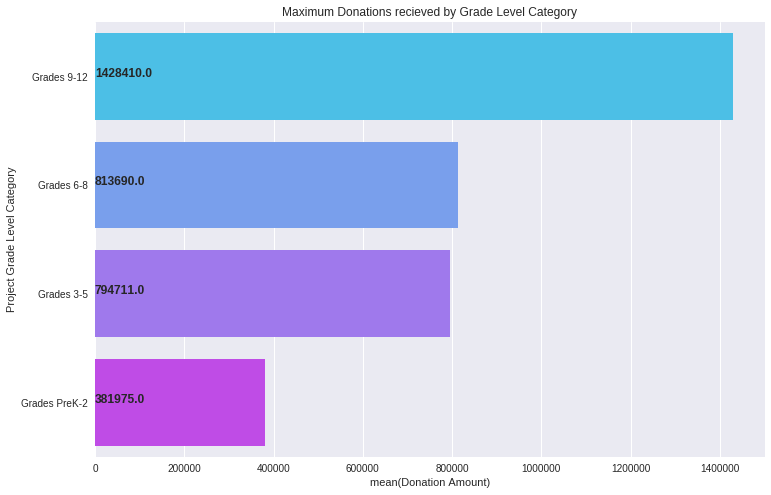

In [0]:
plt.figure(figsize=(12,8))
mnth_amnt = merged_ds_subset.groupby('Project Grade Level Category')["Donation Amount"].sum().reset_index().sort_values(by="Donation Amount",ascending =False)
ax = sns.barplot("Donation Amount",'Project Grade Level Category',data=mnth_amnt,palette="cool")
plt.title("Maximum Donations recieved by Grade Level Category")

for i,j in enumerate(round(mnth_amnt["Donation Amount"],0)):
    ax.text(.7,i,j,weight = "bold")

# merged_ds_subset.groupby('Project Grade Level Category')['Project Grade Level Category'].count().plot.bar()

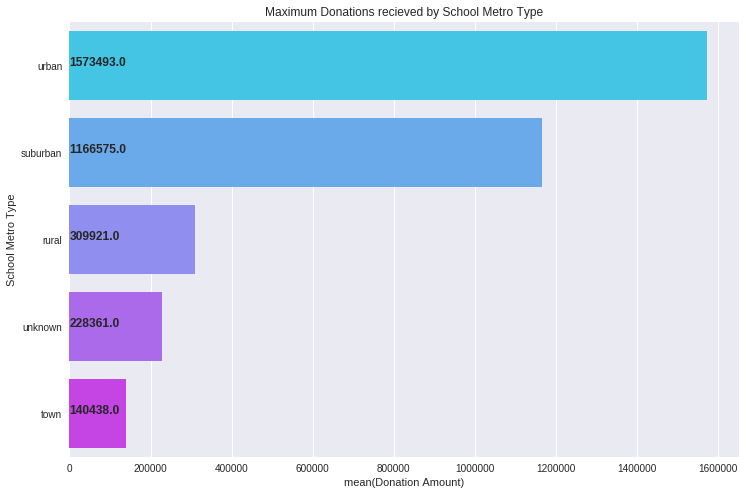

In [0]:
plt.figure(figsize=(12,8))
mnth_amnt = merged_ds_subset.groupby('School Metro Type')["Donation Amount"].sum().reset_index().sort_values(by="Donation Amount",ascending =False)
ax = sns.barplot("Donation Amount",'School Metro Type',data=mnth_amnt,palette="cool")
plt.title("Maximum Donations recieved by School Metro Type")

for i,j in enumerate(round(mnth_amnt["Donation Amount"],0)):
    ax.text(.7,i,j,weight = "bold")

Text(0, 0.5, '')

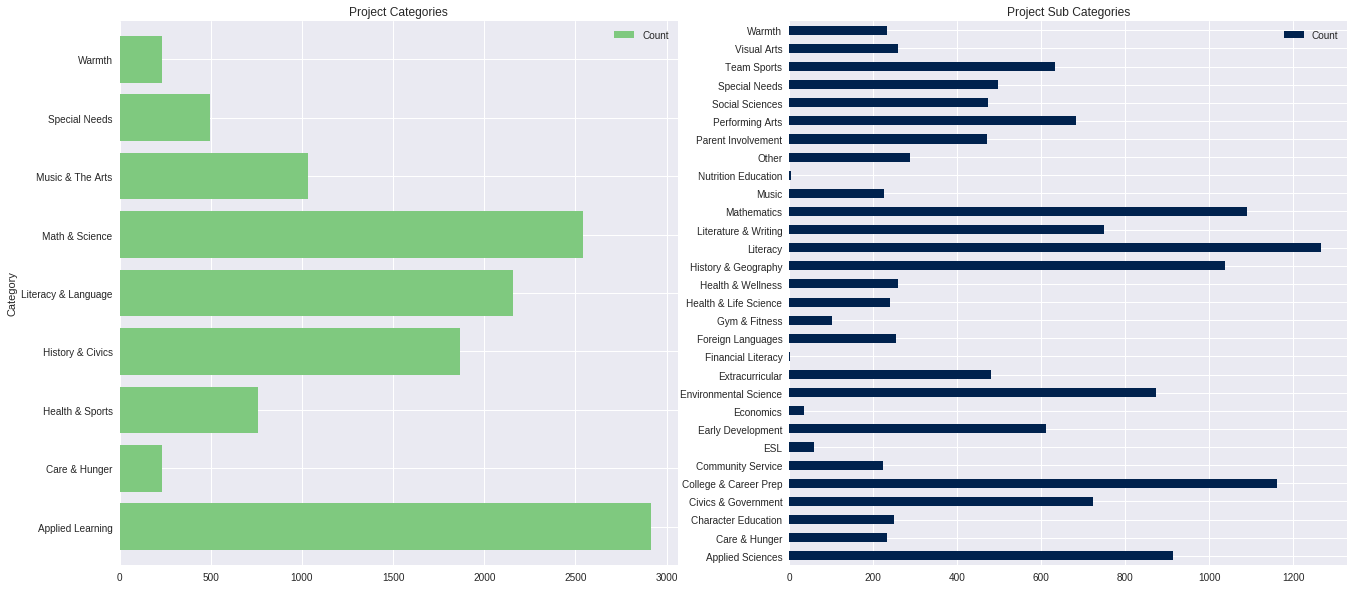

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from itertools import cycle, islice

f,ax=plt.subplots(1,2,figsize=(22,10))

vec = CountVectorizer(tokenizer=lambda x: [i.strip() for i in x.split(',')], lowercase=False)
counts = vec.fit_transform(merged_ds_subset['Project Subject Category Tree'].dropna())
count=dict(zip(vec.get_feature_names(), counts.sum(axis=0).tolist()[0]))
count=pd.DataFrame(list(count.items()),columns=['Category','Count'])
count.set_index('Category',inplace=True)

count.plot.barh(width=0.8,ax=ax[0],colormap='Accent')
ax[0].set_title('Project Categories')


counts = vec.fit_transform(merged_ds_subset['Project Subject Subcategory Tree'].dropna())

count=dict(zip(vec.get_feature_names(), counts.sum(axis=0).tolist()[0]))
count=pd.DataFrame(list(count.items()),columns=['Category','Count'])
count.set_index('Category',inplace=True)
count.plot.barh(width=0.5,ax=ax[1],colormap='cividis')

ax[1].set_title('Project Sub Categories')
ax[1].set_ylabel('')

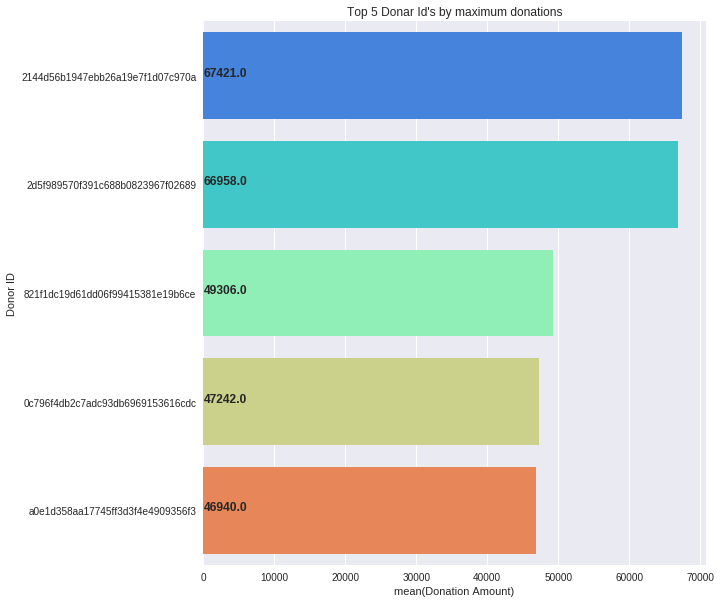

In [0]:
top_donors = merged_ds_subset.groupby("Donor ID")["Donation Amount"].sum().reset_index()
top_donors = top_donors.sort_values(by ="Donation Amount",ascending=False)[:5]

plt.figure(figsize=(9,10))
ax = sns.barplot("Donation Amount","Donor ID",data=top_donors,palette="rainbow")
plt.title("Top 5 Donar Id's by maximum donations")

for i,j in enumerate(round(top_donors["Donation Amount"],0)):
    ax.text(.7,i,j,weight = "bold")

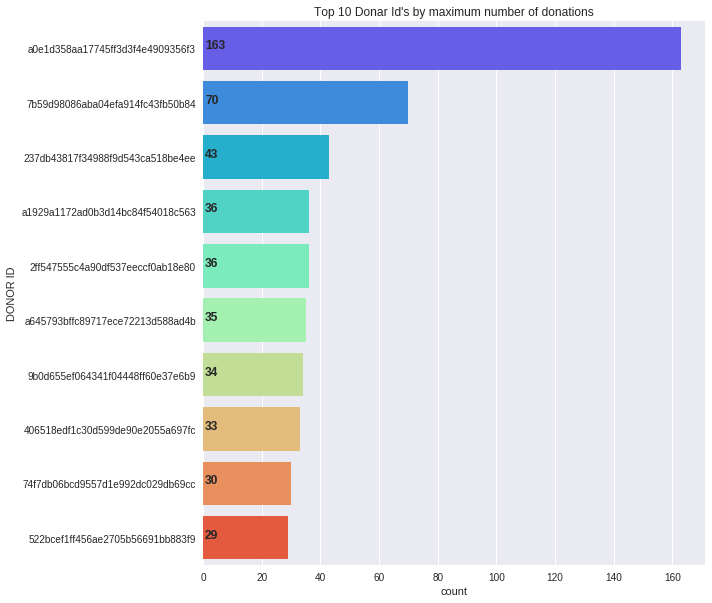

In [0]:
tp_dn = merged_ds_subset["Donor ID"].value_counts().reset_index()[:10]

plt.figure(figsize=(9,10))
ax = sns.barplot("Donor ID","index",data=tp_dn,palette="rainbow")
plt.title("Top 10 Donar Id's by maximum number of donations")
plt.xlabel("count")
plt.ylabel("DONOR ID")

for i,j in enumerate(round(tp_dn["Donor ID"],0)):
    ax.text(.7,i,j,weight = "bold")

Text(0.5, 1.0, 'Top 10 Donor States for contributing maximum donation amount')

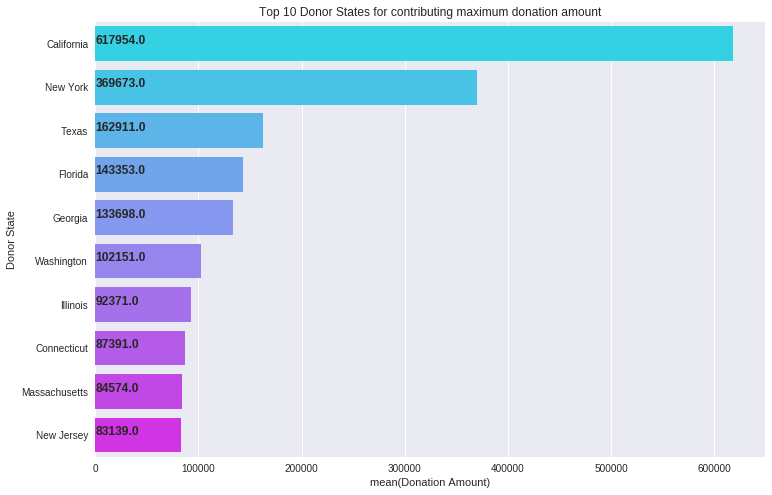

In [0]:
state_dn = merged_ds_subset.groupby("Donor State")["Donation Amount"].sum().reset_index()

s1 = state_dn.sort_values(by="Donation Amount",ascending=False)
s1 = s1[["Donor State","Donation Amount"]][:10]

fig = plt.figure(figsize=(12,8))
# plt.subplot(121)
ax = sns.barplot("Donation Amount","Donor State",data=s1,palette="cool")
for i,j in enumerate(round(s1["Donation Amount"],0)):
    ax.text(.7,i,j,weight = "bold")
plt.title("Top 10 Donor States for contributing maximum donation amount")  

Text(0.5, 1.0, 'Top 10 School States for contributing maximum donation amount')

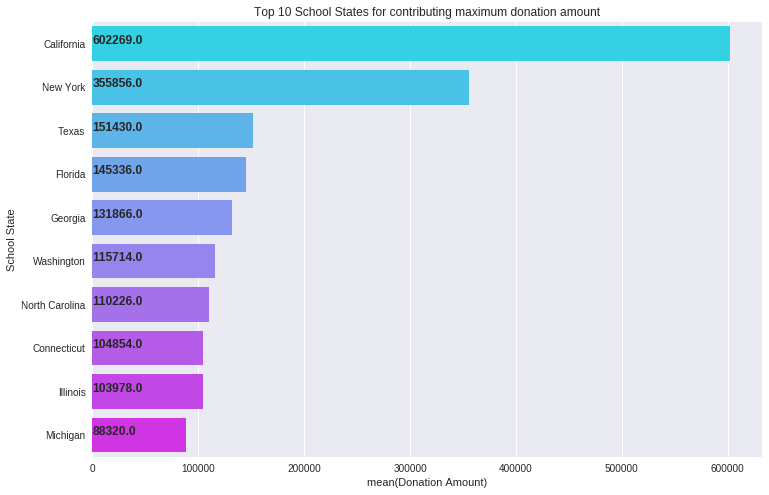

In [0]:
state_school_dn = merged_ds_subset.groupby("School State")["Donation Amount"].sum().reset_index()

s2 = state_school_dn.sort_values(by="Donation Amount",ascending=False)
s2 = s2[["School State","Donation Amount"]][:10]

fig = plt.figure(figsize=(12,8))
# plt.subplot(121)
ax = sns.barplot("Donation Amount","School State",data=s2,palette="cool")
for i,j in enumerate(round(s2["Donation Amount"],0)):
    ax.text(.7,i,j,weight = "bold")
plt.title("Top 10 School States for contributing maximum donation amount")  

## Mapping Categorical to Numerical

### LABEL ENCODER

In [0]:
merged_ds_subset = merged_ds_subset[merged_ds_subset['School City'].notnull() & merged_ds_subset['Donor City'].notnull()]
print(merged_ds_subset.shape)

(7244, 36)


In [0]:
merged_ds_subset_labels = merged_ds_subset.copy()

le = preprocessing.LabelEncoder()

cols_to_encode = ['School State','School District','School County','School City','School Metro Type','Donor State','Donor City','Donor Is Teacher',
                 'Project Resource Category','Project Type','Project Current Status','Project Grade Level Category','Donation Included Optional Donation']

# Encoding the variable
merged_ds_subset_labels['School_State_Label'] = le.fit_transform(merged_ds_subset_labels['School State'])
merged_ds_subset_labels['School_District_Label'] = le.fit_transform(merged_ds_subset_labels['School District'])
merged_ds_subset_labels['School_County_Label'] = le.fit_transform(merged_ds_subset_labels['School County'])
merged_ds_subset_labels['School_City_Label'] = le.fit_transform(merged_ds_subset_labels['School City'])
merged_ds_subset_labels['School_MetroType_Label'] = le.fit_transform(merged_ds_subset_labels['School Metro Type'])

merged_ds_subset_labels['Donor_State_Label'] = le.fit_transform(merged_ds_subset_labels['Donor State'])
merged_ds_subset_labels['Donor_City_Label'] = le.fit_transform(merged_ds_subset_labels['Donor City'])
merged_ds_subset_labels['Donor_IsTeacher_Label'] = le.fit_transform(merged_ds_subset_labels['Donor Is Teacher'])

merged_ds_subset_labels['Project_Resource_Category_Label'] = le.fit_transform(merged_ds_subset_labels['Project Resource Category'])
merged_ds_subset_labels['Project_Type_Label'] = le.fit_transform(merged_ds_subset_labels['Project Type'])
merged_ds_subset_labels['Project_Current_Status_Label'] = le.fit_transform(merged_ds_subset_labels['Project Current Status'])
merged_ds_subset_labels['Project_Grade_Level_Category_Label'] = le.fit_transform(merged_ds_subset_labels['Project Grade Level Category'])

merged_ds_subset_labels['Donation_Included_Optional_Donation_Label'] = le.fit_transform(merged_ds_subset_labels['Donation Included Optional Donation'])

# Inverse Transform
# merged_ds_subset['School_State'] = le.inverse_transform(merged_ds_subset['School_State_Label'])

In [0]:
merged_ds_subset_labels.head(2)

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,School ID,Teacher ID,Teacher Project Posted Sequence,...,School_City_Label,School_MetroType_Label,Donor_State_Label,Donor_City_Label,Donor_IsTeacher_Label,Project_Resource_Category_Label,Project_Type_Label,Project_Current_Status_Label,Project_Grade_Level_Category_Label,Donation_Included_Optional_Donation_Label
6420,2c36ce411e3e8f363708e0e9b89a0b34,e98786fd42c58ef3e6dc82303fcdb3d1,327542b0969ee0d0c141a26619cb12e1,Yes,10.0,14,2016-03-10 23:07:36,fd816f382817bb97396dae57c799bccb,327542b0969ee0d0c141a26619cb12e1,7,...,46,4,13,194,1,1,2,1,0,1
6423,701837e791d2049b7aaeb8dca31603ab,d34eec07be77fb8d62f6f45fa19cb7d7,327542b0969ee0d0c141a26619cb12e1,Yes,10.0,11,2014-12-03 23:09:11,fd816f382817bb97396dae57c799bccb,327542b0969ee0d0c141a26619cb12e1,5,...,46,4,13,194,1,1,2,1,0,1


### MULTI LABEL BINARIZER - To convert Categorical variables to Numerical

In [0]:
new = merged_ds_subset_labels.copy().reset_index(drop=True)

mlb = MultiLabelBinarizer()

fit = mlb.fit_transform(new['Project Subject Category Tree'].str.split(', '))

dummy1 = pd.DataFrame(fit,columns='PC_'+mlb.classes_)
new = pd.concat([new,dummy1], axis=1)
new.head(2)


# Inverse Transform for Get Dummies
# inv_fit = mlb.inverse_transform(fit)
# dummy1['PC'] = pd.DataFrame(np.array(inv_fit))

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,School ID,Teacher ID,Teacher Project Posted Sequence,...,Donation_Included_Optional_Donation_Label,PC_Applied Learning,PC_Care & Hunger,PC_Health & Sports,PC_History & Civics,PC_Literacy & Language,PC_Math & Science,PC_Music & The Arts,PC_Special Needs,PC_Warmth
0,2c36ce411e3e8f363708e0e9b89a0b34,e98786fd42c58ef3e6dc82303fcdb3d1,327542b0969ee0d0c141a26619cb12e1,Yes,10.0,14,2016-03-10 23:07:36,fd816f382817bb97396dae57c799bccb,327542b0969ee0d0c141a26619cb12e1,7,...,1,0,0,0,0,1,0,0,0,0
1,701837e791d2049b7aaeb8dca31603ab,d34eec07be77fb8d62f6f45fa19cb7d7,327542b0969ee0d0c141a26619cb12e1,Yes,10.0,11,2014-12-03 23:09:11,fd816f382817bb97396dae57c799bccb,327542b0969ee0d0c141a26619cb12e1,5,...,1,0,0,0,0,1,1,0,0,0


### BINNING - To Range the Values of "Project Cost" & "Donation Amount"

In [0]:
bins = [0,11500,13500,18000,48000]
labels = [1,2,3,4]

new["Project_Cost_Label"] = pd.cut(new['Project Cost'], bins=bins, labels=labels)

print(new[new["Project_Cost_Label"] == 1].shape) #93
print(new[new["Project_Cost_Label"] == 2].shape) #95
print(new[new["Project_Cost_Label"] == 3].shape) #114
print(new[new["Project_Cost_Label"] == 4].shape) #115

(2009, 59)
(1778, 59)
(1686, 59)
(1771, 59)


In [0]:
bins = [0,10,40,80,100,22000]
labels = [1,2,3,4,5]

new["Donation_Amount_Label"] = pd.cut(new['Donation Amount'], bins=bins, labels=labels)

print(new[new["Donation_Amount_Label"] == 1].shape) #93
print(new[new["Donation_Amount_Label"] == 2].shape) #95
print(new[new["Donation_Amount_Label"] == 3].shape) #114
print(new[new["Donation_Amount_Label"] == 4].shape) #115
print(new[new["Donation_Amount_Label"] == 5].shape)

(1766, 60)
(1466, 60)
(1108, 60)
(1547, 60)
(1357, 60)


In [0]:
cols_to_drop = ['School State','School District','School County','School City','School Metro Type', 'Donor State','Donor City','Donor Is Teacher',
                'Project Resource Category','Project Type','Donation Included Optional Donation','Project Subject Category Tree','Donation Amount',
                'Project Cost','Project ID', 'Donation ID', 'Donor ID','School ID','Teacher ID','Project Title', 'Project Essay', 'Project Short Description',
                'Project Need Statement','Project Subject Subcategory Tree','Project Posted Date','Project Expiration Date','Project Current Status',
                'Project Fully Funded Date','Donor Zip', 'School Name','School Percentage Free Lunch','School Zip','Project Grade Level Category',
                'Donation Received Date']

drop_col(new,cols_to_drop)

print("Done!")

Column to Drop is : ['School State', 'School District', 'School County', 'School City', 'School Metro Type', 'Donor State', 'Donor City', 'Donor Is Teacher', 'Project Resource Category', 'Project Type', 'Donation Included Optional Donation', 'Project Subject Category Tree', 'Donation Amount', 'Project Cost', 'Project ID', 'Donation ID', 'Donor ID', 'School ID', 'Teacher ID', 'Project Title', 'Project Essay', 'Project Short Description', 'Project Need Statement', 'Project Subject Subcategory Tree', 'Project Posted Date', 'Project Expiration Date', 'Project Current Status', 'Project Fully Funded Date', 'Donor Zip', 'School Name', 'School Percentage Free Lunch', 'School Zip', 'Project Grade Level Category', 'Donation Received Date'] 

Done!


In [0]:
new.columns

Index(['Donor Cart Sequence', 'Teacher Project Posted Sequence',
       'School_State_Label', 'School_District_Label', 'School_County_Label',
       'School_City_Label', 'School_MetroType_Label', 'Donor_State_Label',
       'Donor_City_Label', 'Donor_IsTeacher_Label',
       'Project_Resource_Category_Label', 'Project_Type_Label',
       'Project_Current_Status_Label', 'Project_Grade_Level_Category_Label',
       'Donation_Included_Optional_Donation_Label', 'PC_Applied Learning',
       'PC_Care & Hunger', 'PC_Health & Sports', 'PC_History & Civics',
       'PC_Literacy & Language', 'PC_Math & Science', 'PC_Music & The Arts',
       'PC_Special Needs', 'PC_Warmth', 'Project_Cost_Label',
       'Donation_Amount_Label'],
      dtype='object')

In [0]:
new.head(2)

,Donor Cart Sequence,Teacher Project Posted Sequence,School_State_Label,School_District_Label,School_County_Label,School_City_Label,School_MetroType_Label,Donor_State_Label,Donor_City_Label,Donor_IsTeacher_Label,...,PC_Care & Hunger,PC_Health & Sports,PC_History & Civics,PC_Literacy & Language,PC_Math & Science,PC_Music & The Arts,PC_Special Needs,PC_Warmth,Project_Cost_Label,Donation_Amount_Label
0,14,7,12,50,42,46,4,13,194,1,...,0,0,0,1,0,0,0,0,1,1
1,11,5,12,50,42,46,4,13,194,1,...,0,0,0,1,1,0,0,0,1,1


In [0]:
type_convert(new,'Donation_Amount_Label', int)
type_convert(new,'Project_Cost_Label', int)

Data Type before conversion: category 

Data Type after conversion: int64
Data Type before conversion: category 

Data Type after conversion: int64


## DECISION TREE

In [0]:
merged_ds_subset.columns

Index(['Project ID', 'Donation ID', 'Donor ID',
       'Donation Included Optional Donation', 'Donation Amount',
       'Donor Cart Sequence', 'Donation Received Date', 'School ID',
       'Teacher ID', 'Teacher Project Posted Sequence', 'Project Type',
       'Project Title', 'Project Essay', 'Project Short Description',
       'Project Need Statement', 'Project Subject Category Tree',
       'Project Subject Subcategory Tree', 'Project Grade Level Category',
       'Project Resource Category', 'Project Cost', 'Project Posted Date',
       'Project Expiration Date', 'Project Current Status',
       'Project Fully Funded Date', 'Donor City', 'Donor State',
       'Donor Is Teacher', 'Donor Zip', 'School Name', 'School Metro Type',
       'School Percentage Free Lunch', 'School State', 'School Zip',
       'School City', 'School County', 'School District'],
      dtype='object')

### Predict "School Metro Type" 
For a new project having cost "xyz" with donation amount "abc"

In [0]:
X= new[['Project_Cost_Label', 'Donation_Amount_Label', 'Donor Cart Sequence', 'Donor_IsTeacher_Label', 'Project_Type_Label']]
X1 = new[['Project_Cost_Label', 'Donation_Amount_Label', 'Donor Cart Sequence', 'Donor_IsTeacher_Label', 'Project_Type_Label','School_MetroType_Label']]
X.head()

,Project_Cost_Label,Donation_Amount_Label,Donor Cart Sequence,Donor_IsTeacher_Label,Project_Type_Label
0,1,1,14,1,2
1,1,1,11,1,2
2,1,1,10,1,2
3,1,1,9,1,2
4,1,1,8,1,2


In [0]:
null_check(X,'X')

X
Number of rows and cols are 7244 and 5
Number of nulls are 
Project_Cost_Label       0
Donation_Amount_Label    0
Donor Cart Sequence      0
Donor_IsTeacher_Label    0
Project_Type_Label       0
dtype: int64 



In [0]:
# X = X[['Project Type']]
y = X1['School_MetroType_Label']
print(X.shape)
print(y.shape)

(7244, 5)
(7244,)


In [0]:
def TrainTestSplit(x,y):
  # Split the dataset into the training set and test set
  # We're splitting the data in 1/3, so out of 30 rows, 20 rows will go into the training set,
  # and 10 rows will go into the testing set.
  xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)
  return xTrain, xTest, yTrain, yTest

def decisionTreefunc(xTrain,yTrain,xTest):
  clf = DecisionTreeClassifier(max_depth=5,random_state=12)
  clf.fit(xTrain, yTrain)
  yPrediction = clf.predict(xTest)
  print("Decision Tree Done!")
  return clf,yPrediction

# def modelMetrics(model,xTest,yTest,yPrediction,x,y):
#   print('Decision Tree Metrics',"\n")
#   print("Decision Tree Accuracy: %.4f" %metrics.accuracy_score(yTest, yPrediction))
#   print("Confusion Matrix %.4f" % confusion_matrix(yTest, yPrediction))

In [0]:
X_train, X_test, y_train, y_test = TrainTestSplit(X,y)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

clf,pred = decisionTreefunc(X_train,y_train,X_test)

(4829, 5) (4829,)
(2415, 5) (2415,)
Decision Tree Done!


In [0]:
print("Decision Tree Accuracy:",metrics.accuracy_score(y_test, pred))

X_test['Predicted'] = pred
X_test['Actual'] = y_test

print("Count of Predicted and Actual Not matching:",len(X_test[X_test['Actual'] != X_test['Predicted']])) #431

# modelMetrics(clf,X_test,y_test,pred,X,y)

Decision Tree Accuracy: 0.6583850931677019
Count of Predicted and Actual Not matching: 825


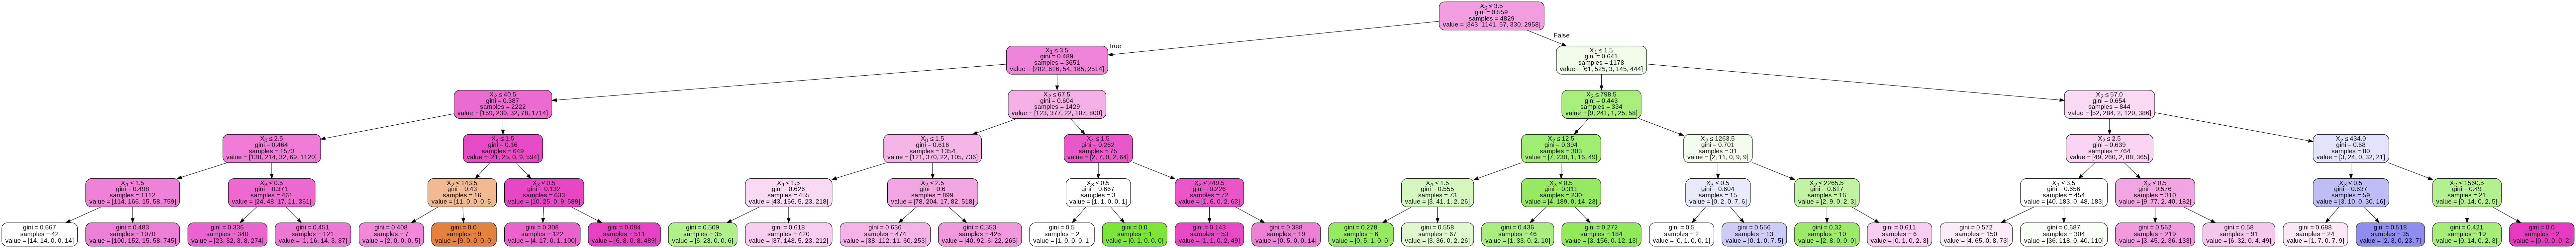

In [0]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
               filled=True, rounded=True,
               special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### Predict "Donation Amount"

In [0]:
X2 = new.drop(['Donation_Amount_Label'], axis=1)
y2 = new['Donation_Amount_Label']

print(X2.shape)
print(y2.shape)

(7244, 25)
(7244,)


In [0]:
X_train2, X_test2, y_train2, y_test2 = TrainTestSplit(X2,y2)
print (X_train2.shape, y_train2.shape)
print (X_test2.shape, y_test2.shape)

clf2,pred_donationamt = decisionTreefunc(X_train2,y_train2,X_test2)

(4829, 25) (4829,)
(2415, 25) (2415,)
Decision Tree Done!


In [0]:
print("Decision Tree Accuracy:",metrics.accuracy_score(y_test2, pred_donationamt))

X_test2['Predicted'] = pred_donationamt
X_test2['Actual'] = y_test2

print("Count of Predicted and Actual Not matching:",len(X_test2[X_test2['Actual'] != X_test2['Predicted']])) #431

Decision Tree Accuracy: 0.46045548654244306
Count of Predicted and Actual Not matching: 1303


In [0]:
# from sklearn.model_selection import cross_val_score, cross_val_predict
# from sklearn import metrics

# # Perform 6-fold cross validation
# scores = cross_val_score(clf2, X2, y2, cv=6)
# print ('Cross-validated scores:', scores)

# scoresparam = cross_val_score(clf2, X2, y2, cv=5, scoring='f1_macro')
# print ('Cross-validated scores new:', scoresparam)

## RANDOM FOREST CLASSIFIER

In [0]:
# Instantiate model with 100 decision trees
rf = ensemble.RandomForestClassifier(random_state=42)

# Train the model on training data
rf.fit(X_train2,y_train2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [0]:
X_train2, X_test2, y_train2, y_test2 = TrainTestSplit(X2,y2)

In [0]:
# Use the forest's predict method on the test data
predictions_rf = rf.predict(X_test2)

print(predictions_rf.shape)

accuracy_RFC = accuracy_score(y_test2, predictions_rf)
print('accuracy_score = ', accuracy_RFC)

(2415,)
accuracy_score =  0.5175983436853002


              precision    recall  f1-score   support

           1       0.71      0.72      0.71       592
           2       0.38      0.39      0.39       501
           3       0.33      0.31      0.32       382
           4       0.54      0.57      0.56       488
           5       0.53      0.52      0.53       452

   micro avg       0.52      0.52      0.52      2415
   macro avg       0.50      0.50      0.50      2415
weighted avg       0.51      0.52      0.52      2415



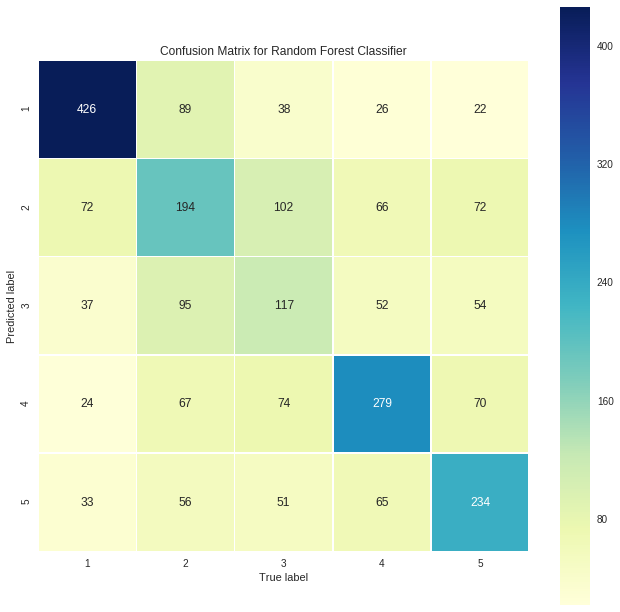

In [0]:
mat_RFC = confusion_matrix(y_test2, predictions_rf)

fig, ax = plt.subplots(figsize=(11,11))  
ax.set_title("Confusion Matrix for Random Forest Classifier")
sns.heatmap(mat_RFC.T, square=True, annot=True, fmt='d', cbar=True,cmap="YlGnBu",
            xticklabels=['1','2','3','4','5'],
            yticklabels=['1','2','3','4','5'],linewidths=.5, ax=ax)
plt.xlabel('True label')
plt.ylabel('Predicted label');

cls_RFC = classification_report(y_test2, predictions_rf, target_names=['1','2','3','4','5'])
print(cls_RFC)